In [6]:
# Code borrowed from https://github.com/stephanie-wang/ownership-osdi20/blob/master/data/Video%20stabilization%20latency.ipynb

import numpy as np
import os

def load(filename, dir=None):
    results = []
    num_over_1000 = 0
    max_frame = -1
    if dir is not None:
        filename = os.path.join(dir, filename)
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            try:
                _, frame, latency = line.split(' ')
            except:
                print(filename, line)
            frame = int(frame)
            latency = float(latency)
            results.append((frame, latency))
            if frame > max_frame:
                max_frame = frame
#     start = 0
#     end = max_frame
    start = max_frame // 4
    end = max_frame - start

    results = [latency * 1000 for frame, latency in results if frame > start and frame < end]
    print(filename)
    print("\tmean", np.mean(results))
    print("\tp50:", np.percentile(results, 50))
    print("\tp90:", np.percentile(results, 90))
    print("\tp99:", np.percentile(results, 99))
    print("\tp100:", np.max(results))
    return results

In [7]:
template = "{}-output{}.txt"

APP_KEEP_FRAMES = template.format("app_keep_frames", "")
APP_LOSE_FRAMES = template.format("app_lose_frames", "")
CHECKPOINT = template.format("checkpoint", "")
LOG = template.format("log", "")

APP_KEEP_FRAMES_FAILURE = template.format("app_keep_frames", "-failure")
APP_LOSE_FRAMES_FAILURE = template.format("app_lose_frames", "-failure")
CHECKPOINT_FAILURE = template.format("checkpoint", "-failure")
LOG_FAILURE = template.format("log", "-failure")

filenames = [APP_KEEP_FRAMES, APP_LOSE_FRAMES, CHECKPOINT, LOG]
failure_filenames = [APP_KEEP_FRAMES_FAILURE, APP_LOSE_FRAMES_FAILURE, CHECKPOINT_FAILURE, LOG_FAILURE]
results = {}
for f in filenames:
    results[f] = load(f, dir="video-data")
for f in failure_filenames:
    results[f] = load(f, dir="video-data")

video-data/app_keep_frames-output.txt
	mean 10.046655916450016
	p50: 9.994745254516602
	p90: 10.556221008300781
	p99: 11.146430969238278
	p100: 12.585639953613281
video-data/app_lose_frames-output.txt
	mean 9.690241670130089
	p50: 9.64808464050293
	p90: 10.197257995605469
	p99: 10.754356384277344
	p100: 11.923789978027344
video-data/checkpoint-output.txt
	mean 9.65069368930166
	p50: 9.643793106079102
	p90: 10.121726989746094
	p99: 10.663771629333496
	p100: 11.469602584838867
video-data/log-output.txt
	mean 50.041216272972896
	p50: 44.75665092468262
	p90: 67.71140098571777
	p99: 137.02722549438445
	p100: 194.2451000213623
video-data/app_keep_frames-output-failure.txt
	mean 9.852498670086813
	p50: 9.8114013671875
	p90: 10.349273681640625
	p99: 10.868411064147944
	p100: 12.726545333862305
video-data/app_lose_frames-output-failure.txt
	mean 9.694745076582736
	p50: 9.677648544311523
	p90: 10.110139846801758
	p99: 10.7551884651184
	p100: 12.55941390991211
video-data/checkpoint-output-failure

/home/swang/anaconda3/envs/ray-wheel/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/swang/anaconda3/envs/ray-wheel/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/swang/anaconda3/envs/ray-wheel/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

<Figure size 432x288 with 0 Axes>

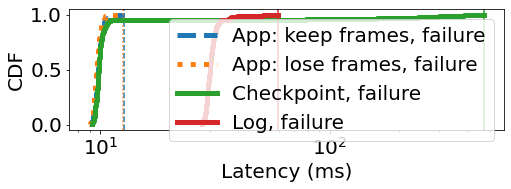

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

SAVE = True
FAILURE = True
DIR = "graphs"

font = {'size': 20}
plt.rc('font', **font)
plt.tight_layout()


index = 0
plt.figure(figsize=(7.5, 3))

def plot(curve, label, linestyle):
    global index
    color = next(plt.axes()._get_lines.prop_cycler)['color']
    n = np.arange(1,len(curve)+1) / np.float(len(curve))
    h, = plt.step(np.sort(curve), n, label=label, linewidth=5, linestyle=linestyle, color=color)
    plt.axvline(max(curve), linestyle=linestyle, color=color)
    index += 1
    return h

if FAILURE:
    curves = [
        (results[APP_KEEP_FRAMES_FAILURE], "App: keep frames, failure", 'dashed'),
        (results[APP_LOSE_FRAMES_FAILURE], "App: lose frames, failure", 'dotted'),
        (results[CHECKPOINT_FAILURE], "Checkpoint, failure", 'solid'),
        (results[LOG_FAILURE], "Log, failure", 'solid'),
    ]
else:
    curves = [
        (results[APP_KEEP_FRAMES], "App: keep frames", 'dashed'),
        (results[APP_LOSE_FRAMES], "App: lose frames", 'dotted'),
        (results[CHECKPOINT], "Checkpoint", 'solid'),
        (results[LOG], "Log", 'solid'),

    ]
    

handles = [None for _ in curves]
labels = [None for _ in curves]
for i, curve in enumerate(curves):
    curve, label, linestyle = curve
    curve = [p for p in curve]
    handles[i] = plot(curve, label, linestyle)
    labels[i] = label
plt.xlabel("Latency (ms)")
plt.xscale('log')
plt.ylabel("CDF")
plt.legend()
plt.tight_layout()


name = "video-latency{}.pdf".format("-failure" if FAILURE else "")
if SAVE:
    plt.savefig(os.path.join(DIR, name))
else:
    plt.show()